<a href="https://colab.research.google.com/github/bence0012/Heart_superresolution/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import image_preprocessing as pre_proc

# Data preprocessing

In this section the data from the ACDC Challenge database is downloaded, extracted and preprocessed to be passed to the network for training. The 4D MRI scans are unrolled into 2D images and padded to be 256 by 256 pixels. Some examples are not fit for preprocessing and they have been thrown away. Then images are downscaled and upsampled to get a 256 by 256 pixels image with a lower resolution.

In [ ]:
pre_proc.download_db()

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

In [ ]:
pre_proc.extract_files()

In [ ]:
pre_proc.unroll_scale_images()

patient059.nii done
patient090.nii done
patient044.nii done
patient058.nii done
patient010.nii done
patient086.nii done
patient077.nii done
patient011.nii done
patient102.nii done
patient122.nii done
patient132.nii done
patient008.nii done
patient072.nii done
patient033.nii done
patient120.nii done
patient043.nii done
patient135.nii done
patient098.nii done
patient123.nii done
patient004.nii done
patient009.nii done
patient075.nii done
patient093.nii done
patient021.nii done
patient065.nii done
patient001.nii done
patient074.nii done
patient119.nii done
patient105.nii done
patient149.nii done
patient099.nii done
patient006.nii done
patient036.nii done
patient045.nii done
patient062.nii done
patient018.nii done
patient020.nii done
patient003.nii done
patient047.nii done
patient127.nii done
patient076.nii done
patient121.nii done
patient117.nii done
patient134.nii done
patient023.nii done
patient064.nii done
patient061.nii done
patient124.nii done
patient084.nii done
patient137.nii done


An example with the result of the downscaling on the rgith and the original image on the left.

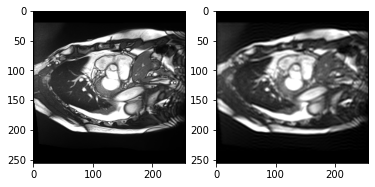

In [ ]:
pre_proc.show_example_images()

# Network Structure

For training we used a GAN model, where there are 2 network that work against each other. A generator network tries to generate super resolution (SR) images from the low resolution (LR) images. The other network the Discriminator network tries to differentiate between original high resolution (HR) and SR images. The  discriminator network forces the generator network to create more and more accurate SR images until it can not tell the difference anymore.

## The Generator Network

The generator network consists of convolutional layers followed by some dense layers. Skip connections help the network learn features from different scales. At this point the network structure is only for demonstration and will change a lot in the future.

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import time
import tensorflow as tf
import keras
from keras.models import Model

def make_generator_model():
    skip=[]

    input=layers.Input(shape=(64*64,))
    x=layers.Reshape((64,64,1,))(input)
    x=layers.Conv2D(32,(4,4),strides=4,padding='same')(x)

    y=x
    skip.append(x)

    x=layers.BatchNormalization(axis=1)(x)
    x = layers.Activation('relu')(x)
    x=layers.Conv2D(16,(3,3),strides=1,padding='same')(x)
    skip.append(x)

    x=layers.Concatenate(axis=3)(skip)

    x=layers.BatchNormalization(axis=1)(x)
    x = layers.Activation('relu')(x)
    x=layers.Conv2D(16,(3,3),strides=1,padding='same')(x)
    skip.append(x)

    x=layers.Concatenate(axis=3)(skip)

    x=layers.BatchNormalization(axis=1)(x)
    x = layers.Activation('relu')(x)
    x=layers.Conv2D(16,(3,3),strides=1,padding='same')(x)
    skip.append(x)

    x=layers.Concatenate(axis=3)(skip)

    x=layers.BatchNormalization(axis=1)(x)
    x = layers.Activation('relu')(x)
    x=layers.Conv2D(16,(3,3),strides=1,padding='same')(x)
    skip.append(x)

    x=layers.Concatenate(axis=3)(skip)
    x=layers.Concatenate(axis=3)([x,y])
    x=layers.Dense(16)(x)
    x=layers.Reshape((64,64,1))(x)

    asd = Model(inputs=input, outputs=x)
    return asd

## The Discriminator Network

The discriminator network is a convolutional network which will also change a lot in the future. To help the problem of vanishing gradient which occurs with many networks with many parameters we use dropout layers. The network outputs a positive number if it thinks the input iamge is real and a negative if it thinks it's fake.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=2, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=1, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=1, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=2, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (3, 3), strides=1, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=2, padding='same'))
    model.add(layers.LayerNormalization(axis=1))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## Evaluation

The discriminator's loss funtion is based on how well it can tell that the real image is real and how well it can tell that the fake image is fake. Because these 2 networks work against each other we can measure the success of the generator network by how well it fooled the discriminator network.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train_generator(generator, X, Y, X_valid, Y_valid, learning_rate, batch_size, epochs):
  generator.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(lr=learning_rate),metrics=['accuracy'])
  generator.fit(X,Y,batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(X_valid,Y_valid),shuffle= True)

In [ ]:
from numpy.lib.shape_base import split
dataset_size=300
train_split=0.7
valid_split=0.2
test_split=0.1

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pre_proc.load_and_transform_data(train_split, valid_split,test_split , dataset_size)

EPOCHS = 1
noise_dim = 64*64
num_examples_to_generate = 1000
BUFFER_SIZE = 600000
BATCH_SIZE = 2

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

X_valid=np.reshape(np.asarray(X_valid)[:,:64,:64],(int(dataset_size*valid_split),4096))
Y_valid=np.asarray(Y_valid)
Y_valid=Y_valid.reshape((int(dataset_size*valid_split),256,256))
Y_valid=np.reshape(np.asarray(Y_valid)[:,:64,:64],(int(dataset_size*valid_split),64,64))
Y_train=Y_train.reshape((int(dataset_size*train_split),256,256))
y=np.reshape(Y_train[:,:64,:64],(int(dataset_size*train_split),64,64))
x=np.reshape(X_train[:,:64,:64],(int(dataset_size*train_split),4096))

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

First we only train the generator to try to generate SR images. Training is only done on one 64 by 64 patch as demonstration.

In [ ]:
train_generator(generator,x,y,X_valid,Y_valid,0.0001,10,500)

C:\Users\levi2\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/500
21/21 - 3s - loss: 0.4975 - accuracy: 0.3762 - val_loss: 0.3937 - val_accuracy: 0.4469 - 3s/epoch - 144ms/step
Epoch 2/500
21/21 - 1s - loss: 0.4934 - accuracy: 0.3766 - val_loss: 0.3990 - val_accuracy: 0.4468 - 1s/epoch - 56ms/step
Epoch 3/500
21/21 - 1s - loss: 0.5337 - accuracy: 0.3733 - val_loss: 0.4256 - val_accuracy: 0.4456 - 1s/epoch - 61ms/step
Epoch 4/500
21/21 - 1s - loss: 0.4921 - accuracy: 0.3744 - val_loss: 0.4001 - val_accuracy: 0.4464 - 1s/epoch - 51ms/step
Epoch 5/500
21/21 - 1s - loss: 0.4763 - accuracy: 0.3757 - val_loss: 0.3979 - val_accuracy: 0.4460 - 1s/epoch - 52ms/step
Epoch 6/500
21/21 - 1s - loss: 0.4919 - accuracy: 0.3757 - val_loss: 0.3969 - val_accuracy: 0.4464 - 1s/epoch - 49ms/step
Epoch 7/500
21/21 - 1s - loss: 0.4971 - accuracy: 0.3762 - val_loss: 0.3937 - val_accuracy: 0.4466 - 1s/epoch - 50ms/step
Epoch 8/500
21/21 - 1s - loss: 0.4886 - accuracy: 0.3761 - val_loss: 0.3706 - val_accuracy: 0.4473 - 1s/epoch - 56ms/step
Epoch 9/500
21/21 - 1s 

KeyboardInterrupt: 

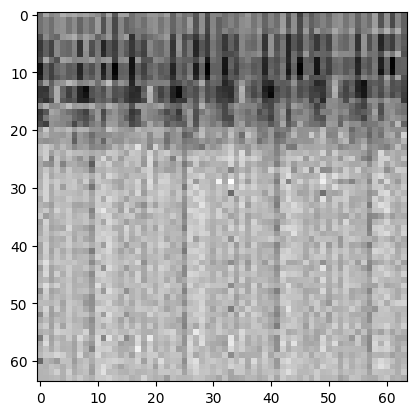

In [ ]:
generated_image = generator(x, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
decision = discriminator(X_train[:,:64,:64,:])
print (decision)

tf.Tensor(
[[13.534576  ]
 [ 4.1855745 ]
 [ 3.3695228 ]
 [ 7.4717526 ]
 [ 6.2348747 ]
 [ 7.165563  ]
 [ 6.530518  ]
 [ 4.3554854 ]
 [ 6.0120225 ]
 [ 1.9424675 ]
 [ 5.8013554 ]
 [ 2.601973  ]
 [ 2.5742002 ]
 [ 3.0376382 ]
 [ 5.6814437 ]
 [ 8.853325  ]
 [13.426923  ]
 [ 1.5173678 ]
 [ 3.2227812 ]
 [ 9.351051  ]
 [ 2.4545388 ]
 [ 4.2787127 ]
 [ 2.600392  ]
 [11.597638  ]
 [ 5.2702804 ]
 [ 5.2181454 ]
 [ 6.108868  ]
 [ 6.708328  ]
 [ 1.1877311 ]
 [ 5.8384695 ]
 [15.912196  ]
 [ 5.043334  ]
 [ 2.695972  ]
 [10.295541  ]
 [ 2.7431095 ]
 [ 4.170696  ]
 [ 1.4860078 ]
 [16.823814  ]
 [ 5.497915  ]
 [ 3.056402  ]
 [ 5.0551033 ]
 [ 1.4629198 ]
 [ 4.8608723 ]
 [ 5.032554  ]
 [11.41963   ]
 [ 2.4733684 ]
 [18.924042  ]
 [ 0.66503745]
 [ 3.9990785 ]
 [ 6.2460856 ]
 [ 3.5223386 ]
 [ 8.656685  ]
 [11.907018  ]
 [ 5.795628  ]
 [ 1.5677534 ]
 [ 4.223991  ]
 [12.9814415 ]
 [ 1.7510494 ]
 [ 5.6245885 ]
 [ 3.2783844 ]
 [ 4.3694735 ]
 [ 1.1769379 ]
 [ 6.0304027 ]
 [ 5.608128  ]
 [ 3.1079655 ]
 [ 3.1782696 ]